## Introduction

In this blog post we will try to understand the ideas introduced in the [FixRes paper](https://arxiv.org/pdf/1906.06423.pdf) published by the Facebook AI Research team.

We will implement the method described in the paper while training a ResNet-50 model from scratch in PyTorch, on the [Cassava leaf disease classification dataset](https://www.kaggle.com/c/cassava-leaf-disease-classification) from Kaggle.

Finally, we will see how we can use this method in fast.ai with transfer learning.

## The train-test resolution discrepancy

The paper shows that existing data augmentation techniques introduces a significant difference in sizes of objects that a CNN sees during training and testing.

During training, it is common to extract/crop a random region of classification from an image and then resize it to a resolution that is compatible with the CNN architecture.

For example, the crop would be resized to 224 x 224 when using AlexNet. However, some architectures like ResNet don't have such a requirement. Even in this case, all images within a batch need to be resized to a common resolution.

This kind of augmentation is what we get with `RandomResizedCrop` in PyTorch.

During testing, however, we just extract a center crop of the size we would like to feed to the model.

The result of this difference during training and testing is this:

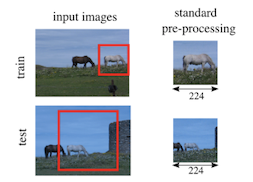

This image shows that although we are providing the same resolution of images to the model during training and testing, the scale of horses that the model sees during these phases is different.

This is because the nature of preprocessing used tends to zoom on objects, resulting in a larger horse during training compared to testing.

This is a problem because convolutional neural networks do not have "built-in scale invariance", i.e. they are sensitive to the sizes of objects in the images used to train them.

## Fixing the apparent object size problem

To fix this discrepancy in the apparent size of objects during training and testing, the authors propose two options:

1. **Decrease** the resolution of images during **training**.
2. **Increase** the resolution of images during **testing**.

As a result, the model will see horses of the same size.

The authors found that the ratio of the size of objects seen at test time to size of objects seen at train time lies between between 0.28 and 1.

This means that during test time, some objects may appear to be just a third of their size during training time!

With standard pre-processing, the authors claim that objects at test time are on average 0.8 times what they appear at training time.

This means that if we choose to decrease the resolution of images during training, we need to make it 0.8 times the resolution we use during training.

If we choose to increase the resolution of images during testing instead, then we need to make them $1/0.8 = 1.25$ times the resolution used during training.

For example, if we have images of resolution 224 x 224, we could adjust the resolution in one of the following ways:

| Method | Resolution at training time | Resolution at test time |
| ------ | --------------------------- | ----------------------- |
| Decrease resolution at training time | $0.8 \times 224 = 179$ | $224$ |
| Increase resolution at training time | $224$ | $224 * 1.25 = 280$ |

*Table 1: Adjusted training and test resolutions for images of size 224x224*


Wouldn't life be so wonderful if everything "just worked" when we did this?

Unfortunately, the authors discovered that changing the resolution of images during testing significantly skews the distribution of activations in the model.

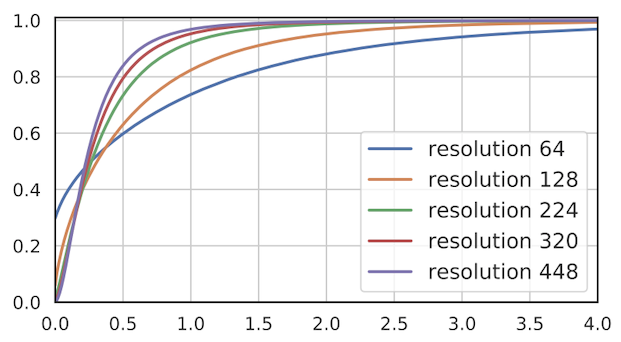

This graph shows the cumulative density of activations after average pooling layer for a ResNet-50 trained at a resolution of 224 and tested at the different resolutions shown.

As we can see, lower resolutions result in more activations being 0 and activations are more spread out. At higher resolutions, we see the opposite - the number of 0 activations drops and the activations are less spread out.

If the distribution of activations significantly change at test time, their values will not be in the range that the final classifier was trained for. As a result, the accuracy of the model will suffer.

## Fixing the skewed activation statistics

CNNs consist of two major parts:

1. The convolutional part consisting of linear convolutions, subsampling, ReLU activations and other similar layers.
2. The pooling part, which is usually average pooling, to produce a fixed-size vector for classification.

Changing the size of the input fed to a model strongly affects the distribution of activations of the second part.

The authors mention two ways to deal with these skewed activations:

1. Parametric adaptation
2. Fine-tuning

The authors mention that parametric adaptation provided a measurable but limited improvement in accuracy. Therefore, we'll focus on how to fine-tune the model instead.

A change in resolution of images at test time is effectively a domain shift, and a common way to deal with domain shift is fine-tuning the model.

When fine-tuning the model we use the same images from the training set but with a higher resolution.

The authors also mention that we need to fine-tune the last few layers of the model which includes any batch normalization layer that precedes the pooling layer.

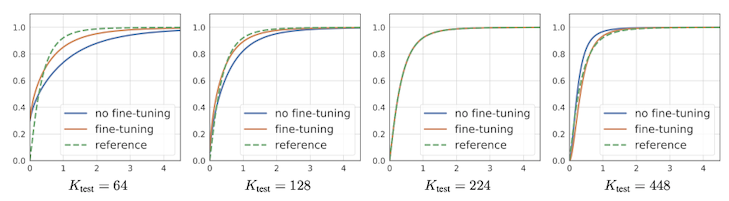

This image from the paper shows how fine-tuning the batch-norm layer brings the distribution of activations from the pooling layer closer to the initial distribution (when using images of the same resolution for training and testing).

## Training a model using PyTorch

We will now test the effectiveness of this method using the [Cassava leaf disease classification dataset](https://www.kaggle.com/c/cassava-leaf-disease-classification) from Kaggle.

We will first train a baseline model and then compare its performance with another one we train using the FixRes method.

### Baseline model

In [1]:
import pandas as pd

import torch

import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from PIL import Image

import copy
import os
import time

# Ignore warnings to keep the output nice and pretty
import warnings
warnings.filterwarnings("ignore")

The train-test split being used was created in a [Fastbook reading group](https://community.wandb.ai/c/community-events/fastbook/8) and can be found [here](https://www.kaggle.com/aroraaman/wandbcassava).

In [2]:
df = pd.read_csv('../wandb_cassava_train_val_split.csv')
df.head()

,image_id,label,is_val
0,1000015157.jpg,0,False
1,1000201771.jpg,3,False
2,100042118.jpg,1,False
3,1000723321.jpg,1,False
4,1000812911.jpg,3,False


We first create a `Dataset` for the data.

In [3]:
class CassavaDataset(Dataset):
    
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform=transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        
        image = Image.open(img_path)
        label = self.df.iloc[idx, 1]

        sample = {"image": image, "label": label}
        
        if self.transform:
            sample["image"] = self.transform(sample["image"])
        
        return sample

We then define the augmentation we'll use during training and testing.

As you can see, we use `RandomResizedCrop` during training and `CenterCrop` during testing with the same size.

In [4]:
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]),
        'val': transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]),
    }

We can now create training and validation datasets.

In [5]:
def get_datasets(data_transforms):
    train_ds = CassavaDataset(df[df.is_val == False].reset_index(drop=True), '../train_images', data_transforms['train'])
    val_ds = CassavaDataset(df[df.is_val == True].reset_index(drop=True), '../train_images', data_transforms['val'])

    return {
        "train": train_ds,
        "val": val_ds
    }

datasets = get_datasets(data_transforms)
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

The next step is to create data loaders for these datasets.

In [6]:
def get_dataloaders(datasets, bs=64):
    return {
        "train": DataLoader(datasets["train"], batch_size=bs, shuffle=True, num_workers=4),
        "val": DataLoader(datasets["val"], batch_size=bs, shuffle=True, num_workers=4)
    }

dataloaders = get_dataloaders(datasets)

We now create three utility methods:

1. `train_loop` to train the model for one epoch
2. `eval_loop` to evaluate the model on validation data for one epoch
3. `train` to call `train_loop` and `eval_loop` for the number of epochs specified, and also to keep track of the best model weights.

In [7]:
def train_loop(model, dataloader, criterion, optimizer, ds_size, fine_tune):
    
    # Will be used later for fine-tuning model at a higher resolution
    if fine_tune:
        model.eval()
        model.layer4[2].bn3.train()
    else:
        model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    for sample in dataloader:
        inputs = sample["image"].to(device)
        labels = sample["label"].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        
    epoch_loss = running_loss / ds_size
    epoch_acc = running_corrects.double() / ds_size
    
    return epoch_loss, epoch_acc
    
            
        
        
def eval_loop(model, dataloader, criterion, ds_size):
    
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
    
        for sample in dataloader:
            inputs = sample["image"].to(device)
            labels = sample["label"].to(device)
        
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / ds_size
    epoch_acc = running_corrects.double() / ds_size
    
    return epoch_loss, epoch_acc
    


def train(
        model, train_loader, val_loader,
        epochs, criterion, optimizer,
        fine_tune=False
    ):
    
    train_start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        
        epoch_start = time.time()
        
        train_loss, train_acc = train_loop(
            model, train_loader, criterion,
            optimizer, dataset_sizes["train"],
            fine_tune=fine_tune
        )
        
        val_loss, val_acc = eval_loop(
            model, val_loader, criterion, dataset_sizes["val"]
        )
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        time_elapsed = time.time() - epoch_start
        print(f'Epoch: {epoch+1:02} | Epoch Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
        
        
    time_elapsed = time.time() - train_start
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We create an instance of a `resnet50` model that we will use. We need to modify the fully connected layer so that the number of ouputs equals the number of classes we have in our dataset.

In [8]:
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, df.label.unique().size)

# Use the power of the GPU! 💪
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

We now train the model for 10 epochs using the AdamW optimizer with default parameters.

In [9]:
N_EPOCHS=10

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=0.1)

model = train(model, dataloaders["train"], dataloaders["val"], N_EPOCHS, criterion, optimizer)

Epoch: 01 | Epoch Time: 3m 1s
	Train Loss: 1.105 | Train Acc: 62.14%
	 Val. Loss: 1.139 |  Val. Acc: 61.58%
Epoch: 02 | Epoch Time: 3m 8s
	Train Loss: 0.928 | Train Acc: 64.79%
	 Val. Loss: 1.594 |  Val. Acc: 23.35%
Epoch: 03 | Epoch Time: 3m 8s
	Train Loss: 0.873 | Train Acc: 67.02%
	 Val. Loss: 2.089 |  Val. Acc: 13.58%
Epoch: 04 | Epoch Time: 3m 8s
	Train Loss: 0.819 | Train Acc: 68.94%
	 Val. Loss: 1.667 |  Val. Acc: 33.68%
Epoch: 05 | Epoch Time: 3m 12s
	Train Loss: 0.776 | Train Acc: 70.80%
	 Val. Loss: 1.022 |  Val. Acc: 64.71%
Epoch: 06 | Epoch Time: 3m 8s
	Train Loss: 0.757 | Train Acc: 71.75%
	 Val. Loss: 1.000 |  Val. Acc: 64.95%
Epoch: 07 | Epoch Time: 3m 8s
	Train Loss: 0.736 | Train Acc: 72.81%
	 Val. Loss: 1.207 |  Val. Acc: 63.29%
Epoch: 08 | Epoch Time: 3m 8s
	Train Loss: 0.710 | Train Acc: 73.63%
	 Val. Loss: 1.155 |  Val. Acc: 51.16%
Epoch: 09 | Epoch Time: 3m 8s
	Train Loss: 0.702 | Train Acc: 74.31%
	 Val. Loss: 0.926 |  Val. Acc: 66.77%
Epoch: 10 | Epoch Time: 3m 

In [10]:
torch.save(model.state_dict(), 'blog-1.pt')

The baseline model has an accuracy of 71.09%.

### Higher resolution images during testing

The first way to use FixRes is by increasing the resolution of images at test time.

In [15]:
test_sizes = [64, 128, 224, 384, 480]

accuracy = []

for size in test_sizes:

    trans = transforms.Compose([
            transforms.Resize(int(1.25 * size)),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
        ])

    val_ds = CassavaDataset(df[df.is_val == True].reset_index(drop=True), '../train_images', trans)
    ds_size = len(val_ds)
    dataloader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4)

    loss, acc = eval_loop(model, dataloader, criterion, ds_size)
    
    accuracy.append(acc.item())

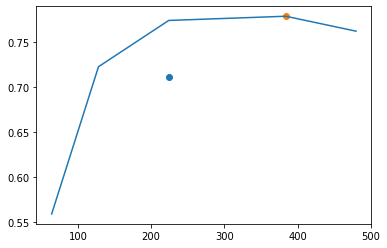

In [35]:
import matplotlib.pyplot as plt

max_acc = max(accuracy)
max_res = test_sizes[accuracy.index(max_acc)]

plt.plot(test_sizes, accuracy)
plt.scatter(224, 0.7109)
plt.scatter(max_res, max_acc)
plt.show()

We can see that using a larger image resolution increases the accuracy from 71.09% (the blue dot) to 77.89% at a resolution of 384 (the orange dot).

Note that using Resize (1.25 * 224) + CenterCrop (224) gives a higher accuracy than using just CenterCrop (224). This shows that the size of objects seen by the model is indeed different at test time and has an adverse effect on the accuracy.

Also note that we have obtained a better accuracy from the model without even fine-tuning the model at a larger resolution!

Let us now fine-tune the last layers of the model at a resolution of 384, since that's the resolution at which the model performed best.

In [9]:
model.load_state_dict(torch.load('blog-1.pt'))

<All keys matched successfully>

In [10]:
# Freeze all layers apart from the fully connected layer
for name, child in model.named_children():
    if 'fc' not in name:
        for _, params in child.named_parameters():
            params.requires_grad = False
    
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(384),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]),
        'val': transforms.Compose([
            transforms.Resize(480),
            transforms.CenterCrop(384),
            transforms.ToTensor(),
        ]),
    }

datasets = get_datasets(data_transforms)
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
dataloaders = get_dataloaders(datasets)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=0.1)

model = train(model, dataloaders["train"], dataloaders["val"], 5, criterion, optimizer, fine_tune=True)

Epoch: 01 | Epoch Time: 3m 20s
	Train Loss: 0.650 | Train Acc: 76.00%
	 Val. Loss: 0.582 |  Val. Acc: 79.46%
Epoch: 02 | Epoch Time: 3m 22s
	Train Loss: 0.642 | Train Acc: 76.78%
	 Val. Loss: 0.587 |  Val. Acc: 79.67%
Epoch: 03 | Epoch Time: 3m 22s
	Train Loss: 0.632 | Train Acc: 76.88%
	 Val. Loss: 0.588 |  Val. Acc: 79.67%
Epoch: 04 | Epoch Time: 3m 23s
	Train Loss: 0.644 | Train Acc: 76.59%
	 Val. Loss: 0.589 |  Val. Acc: 79.53%
Epoch: 05 | Epoch Time: 3m 23s
	Train Loss: 0.640 | Train Acc: 76.72%
	 Val. Loss: 0.585 |  Val. Acc: 79.46%

Training complete in 16m 50s
Best val Acc: 0.796681


By passing `fine_tune=True` to the `train` method, we ensured that the entire model was in `eval` mode and just the last BatchNorm layer before the pooling layer was in `train` mode.

And fine-tuning was indeed helpful! It bumped the accuracy of our model from 77.89% to 79.67%!

### Lower resolution images during training


We could have used images with a lower resolution during training instead of increasing the resolution of images during testing.

From the calculations in Table 1, we would use images of resolution 179x179 during training and images of resolution 224x224 during testing.

Training the model with these resolutions is left as an exercise for the reader. 👀

## Transfer learning using fast.ai

The FixRes method can also be used with transfer learning. The authors mention that when fine-tuning a pre-trained model, they do the following:

1. Initialize the model with pre-trained weights
2. Train the entire model for several epochs at the training resolution
3. Fine-tune the last BatchNorm and fully connected layer with a higher resolution

We will try this approach with fast.ai.

The code that follows was inspired by [@morgymcg](https://twitter.com/morgymcg)'s experiments available on GitHub: [morganmcg1/fastgarden](https://github.com/morganmcg1/fastgarden/blob/master/fixres_experiments.ipynb)

We will continue using the same dataset and the same train-test split described at the beginning of the PyTorch experiments.

In [21]:
from fastai.vision.all import *

path = Path('..')
def get_x(row):
    return path/'train_images'/row['image_id']

def get_y(row):
    return row['label']

def splitter(df):
    train = df.index[~df['is_val']].tolist()
    valid = df.index[df['is_val']].tolist()
    return train, valid

def get_dls(size=224):
    cassava = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_x=get_x,
        get_y=get_y,
        splitter=splitter,
        item_tfms=[RandomResizedCrop(size, min_scale=0.7)],
        batch_tfms=[*aug_transforms()]
    )
    dls = cassava.dataloaders(df, bs=64)
    return dls

We create a ResNet-50 with pretrained weights and then train the entire network at a resolution of 224x224.

In [22]:
dls = get_dls()
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.067555,0.806518,0.727506,02:55


epoch,train_loss,valid_loss,accuracy,time
0,0.675441,0.725409,0.757887,03:44
1,0.543039,0.556987,0.820986,03:44
2,0.463506,0.510089,0.833606,03:44
3,0.340905,0.478553,0.843188,03:44
4,0.276000,0.470489,0.849965,03:44


We then freeze the earlier layers of the model and fine-tune the last layer with a higher resolution.

In [23]:
learn.export('blog-2.pkl')

In [24]:
new_dls = get_dls(size=280)
learn.dls = new_dls
learn.freeze()
learn.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.319706,0.466751,0.856509,04:38
1,0.298980,0.547480,0.825193,04:34
2,0.286727,0.461916,0.858378,04:34
3,0.280145,0.508987,0.841785,04:34
4,0.268317,0.517633,0.842253,04:34


This gives us a peak accuracy of 85.84%!

The process is very similar to [progressive resizing](https://ravimashru.dev/blog/2021-08-11-fastbook-ch7/). The difference is that with progressive resizing, we train the entire network with larger images. But with FixRes, we are just fine-tuning the last layers of the network with larger images.

## Conclusion

Standard data augmentation techniques change the apparent size of objects during training.

As a result, the model sees objects of different scale during training and testing. This is a problem because CNNs are not scale invariant.

This can be remedied by training with smaller images, or testing with larger images.

However, using images of different size at train time and test time negatively affects the classifier layers of the CNN.

To address this, we fine tune the last few layers of the model, including the batch-norm layer preceding the global pooling layer at the higher resolution being used at test time.

This approach can be used when training a model from scratch and also with transfer learning.


## References

- [Fixing the train-test resolution discrepancy](https://arxiv.org/abs/1906.06423)
- [GitHub: facebookresearch/FixRes](https://github.com/facebookresearch/FixRes)
- [FixRes blog post by Morgan McGuire](https://www.ntentional.com/papers/training%20technique/classification/2020/04/15/fixres.html)

## Acknowledgements

* **[Aman Arora](https://twitter.com/amaarora)** for the amazing [Fastbook reading group](https://community.wandb.ai/c/community-events/fastbook/8) sessions where he introduced this paper to us, for encouraging us to start reading research papers and for motivating us to actively write about what we learn in our deep learning journey.

* **[Sanyam Bhutani](https://twitter.com/bhutanisanyam1)** for running the [PyTorch book reading group](https://community.wandb.ai/c/community-events/pytorch-book/32) sessions and encouraging us to have a bias towards action - writing code and trying things out instead of just reading. The PyTorch code I managed to write in this blog post is a result of the awesome study group he's running.

* **[Morgan McGuire](https://twitter.com/morgymcg)** for making his amazing [fastgarden of FixRes experiments](https://github.com/morganmcg1/fastgarden/blob/master/fixres_experiments.ipynb) available on GitHub which made it very easy for me to understand how to use FixRes with fastai.
